In [1]:
%reload_ext autoreload
%autoreload 2

from itertools import product

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

from mcopt.util.io import load_complex
from mcopt.morse_graph import (
  MorseGraph, 
  color_by_position,
  attribute_cost_mat
)
from mcopt.opt import (GW, fGW, pGW, fpGW, color_transfer)
from util import find_good_init

# Configuration

In [2]:
datasets = [
  'wind1',
  'wind2',
  'wind3',
  'wind4',
  'wind5',
  'wind6',
  'wind7',
  'wind8',
  'wind9',
  'wind10',
  'wind11',
  'wind12',
  'wind13',
  'wind14',
  'wind15',
]

src = 'wind1'

# Configuration for graph sampling
sampling_frequency = 5
sampling_mode = 'geo_dist'

# Configuration for Measure Network conversion
weight = 'path_length'
hist = 'deg'

# Configuration for transport
n_iter = 10
random_state = 42

# Configuration for fpGW
alpha = 0.5
m = 0.95

# Configuration for figures
cmap = 'cool'

# Load Complexes and generate Graphs

In [3]:
src_complex = load_complex(f'../gen_data/{src}')

results = {}

for dataset in datasets:
  if dataset == src:
    continue
  
  results[dataset] = {
    'complex': load_complex(f'../gen_data/{dataset}')
  }

In [4]:
src_graph = MorseGraph.from_complex(src_complex).sample(sampling_frequency,  mode=sampling_mode)

for _, result in results.items():
  complex = result['complex']
  
  result['graph'] = MorseGraph.from_complex(complex).sample(sampling_frequency,  mode=sampling_mode)

## Display Initial Graphs

/home/merlin/Workspace/github.com/stormymcstorm/MCOpt/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


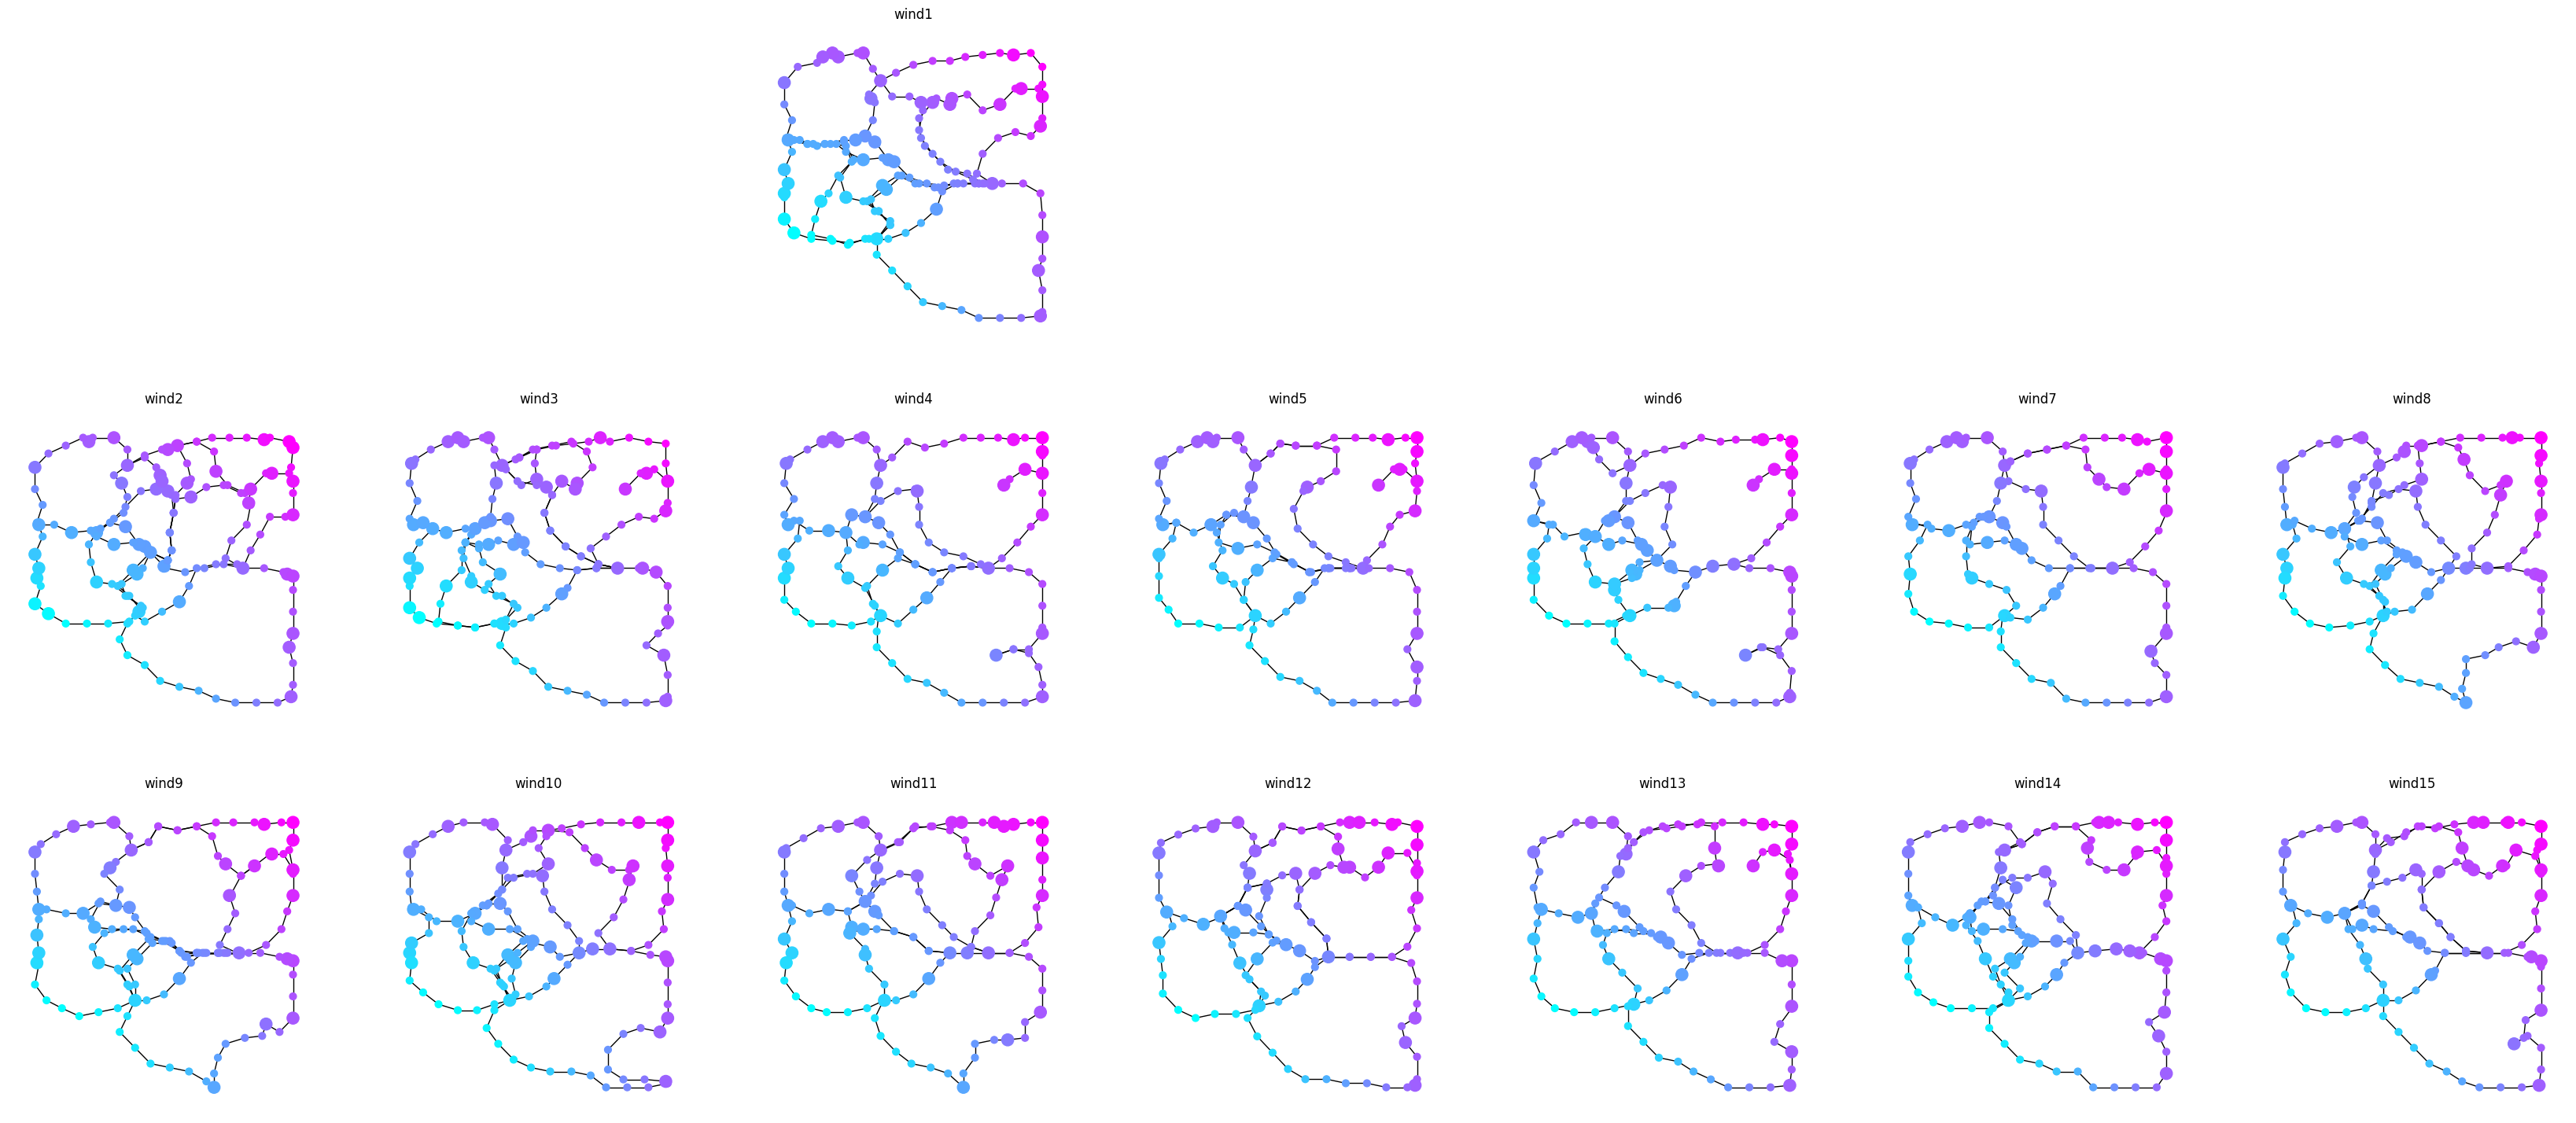

In [5]:
w = len(results) // 2
h = 3

fig, axs = plt.subplots(3, w, figsize=(6 * w, 3 * 6))

for ax in axs.ravel():
  ax.set_axis_off()

src_pos = (0,w // 2 - 1)
src_graph.draw(ax=axs[src_pos], node_size=40, cmap=cmap)
axs[src_pos].set_title(src)

for ax, (name, res) in zip(axs[1:,:].ravel(), results.items()):
  res['graph'].draw(ax=ax, node_size=40, cmap=cmap)
  ax.set_title(name)

# Run Fused Optimal Transport

In [6]:
src_net = src_graph.to_measure_network(weight=weight, hist=hist)

for _, res in results.items():
  dest_graph = res['graph']
  
  dest_net = dest_graph.to_measure_network(weight=weight, hist=hist)
  
  res['net'] = dest_net
  
  M = attribute_cost_mat(src_graph, dest_graph)
  
  def run_GW(G0):
    return GW(src_net, dest_net, G0=G0)
  
  def run_fGW(G0):
    return fGW(src_net, dest_net, M, alpha=alpha, G0=G0)
  
  def run_fpGW(G0):
    return fpGW(src_net, dest_net, m, M, alpha=alpha, G0=G0)
    
  
  res['GW'] = find_good_init(run_GW, src_net, dest_net, random_state, n_iter)
  res['fGW'] = find_good_init(run_fGW, src_net, dest_net, random_state, n_iter)
  res['fpGW'] = find_good_init(run_fpGW, src_net, dest_net, random_state, n_iter)


## Display Color Transfer

In [7]:
w = len(results) // 2
h = 3

def show_transfer(coupling_key):
  fig, axs = plt.subplots(3, w, figsize=(6 * w, 3 * 6))

  for ax in axs.ravel():
    ax.set_axis_off()

  src_pos = (0,w // 2 - 1)
  src_node_color = color_by_position(src_graph)

  src_graph.draw(
    ax=axs[src_pos], 
    node_size=40, 
    node_color = src_node_color,
    cmap=cmap
  )
  axs[src_pos].set_title(src)

  for ax, (name, res) in zip(axs[1:,:].ravel(), results.items()):
    dest_graph = res['graph']
    dest_net = res['net']
    
    coupling = res[coupling_key]
    
    dest_node_color = color_transfer(
      src_net,
      dest_net,
      coupling,
      src_node_color
    )
  
    dest_graph.draw(
      ax=ax, 
      node_size=40, 
      node_color=dest_node_color,
      cmap=cmap,
    )
    
    ax.set_title(name)
    
  return fig

Text(0.5, 0.98, 'GW Transport')

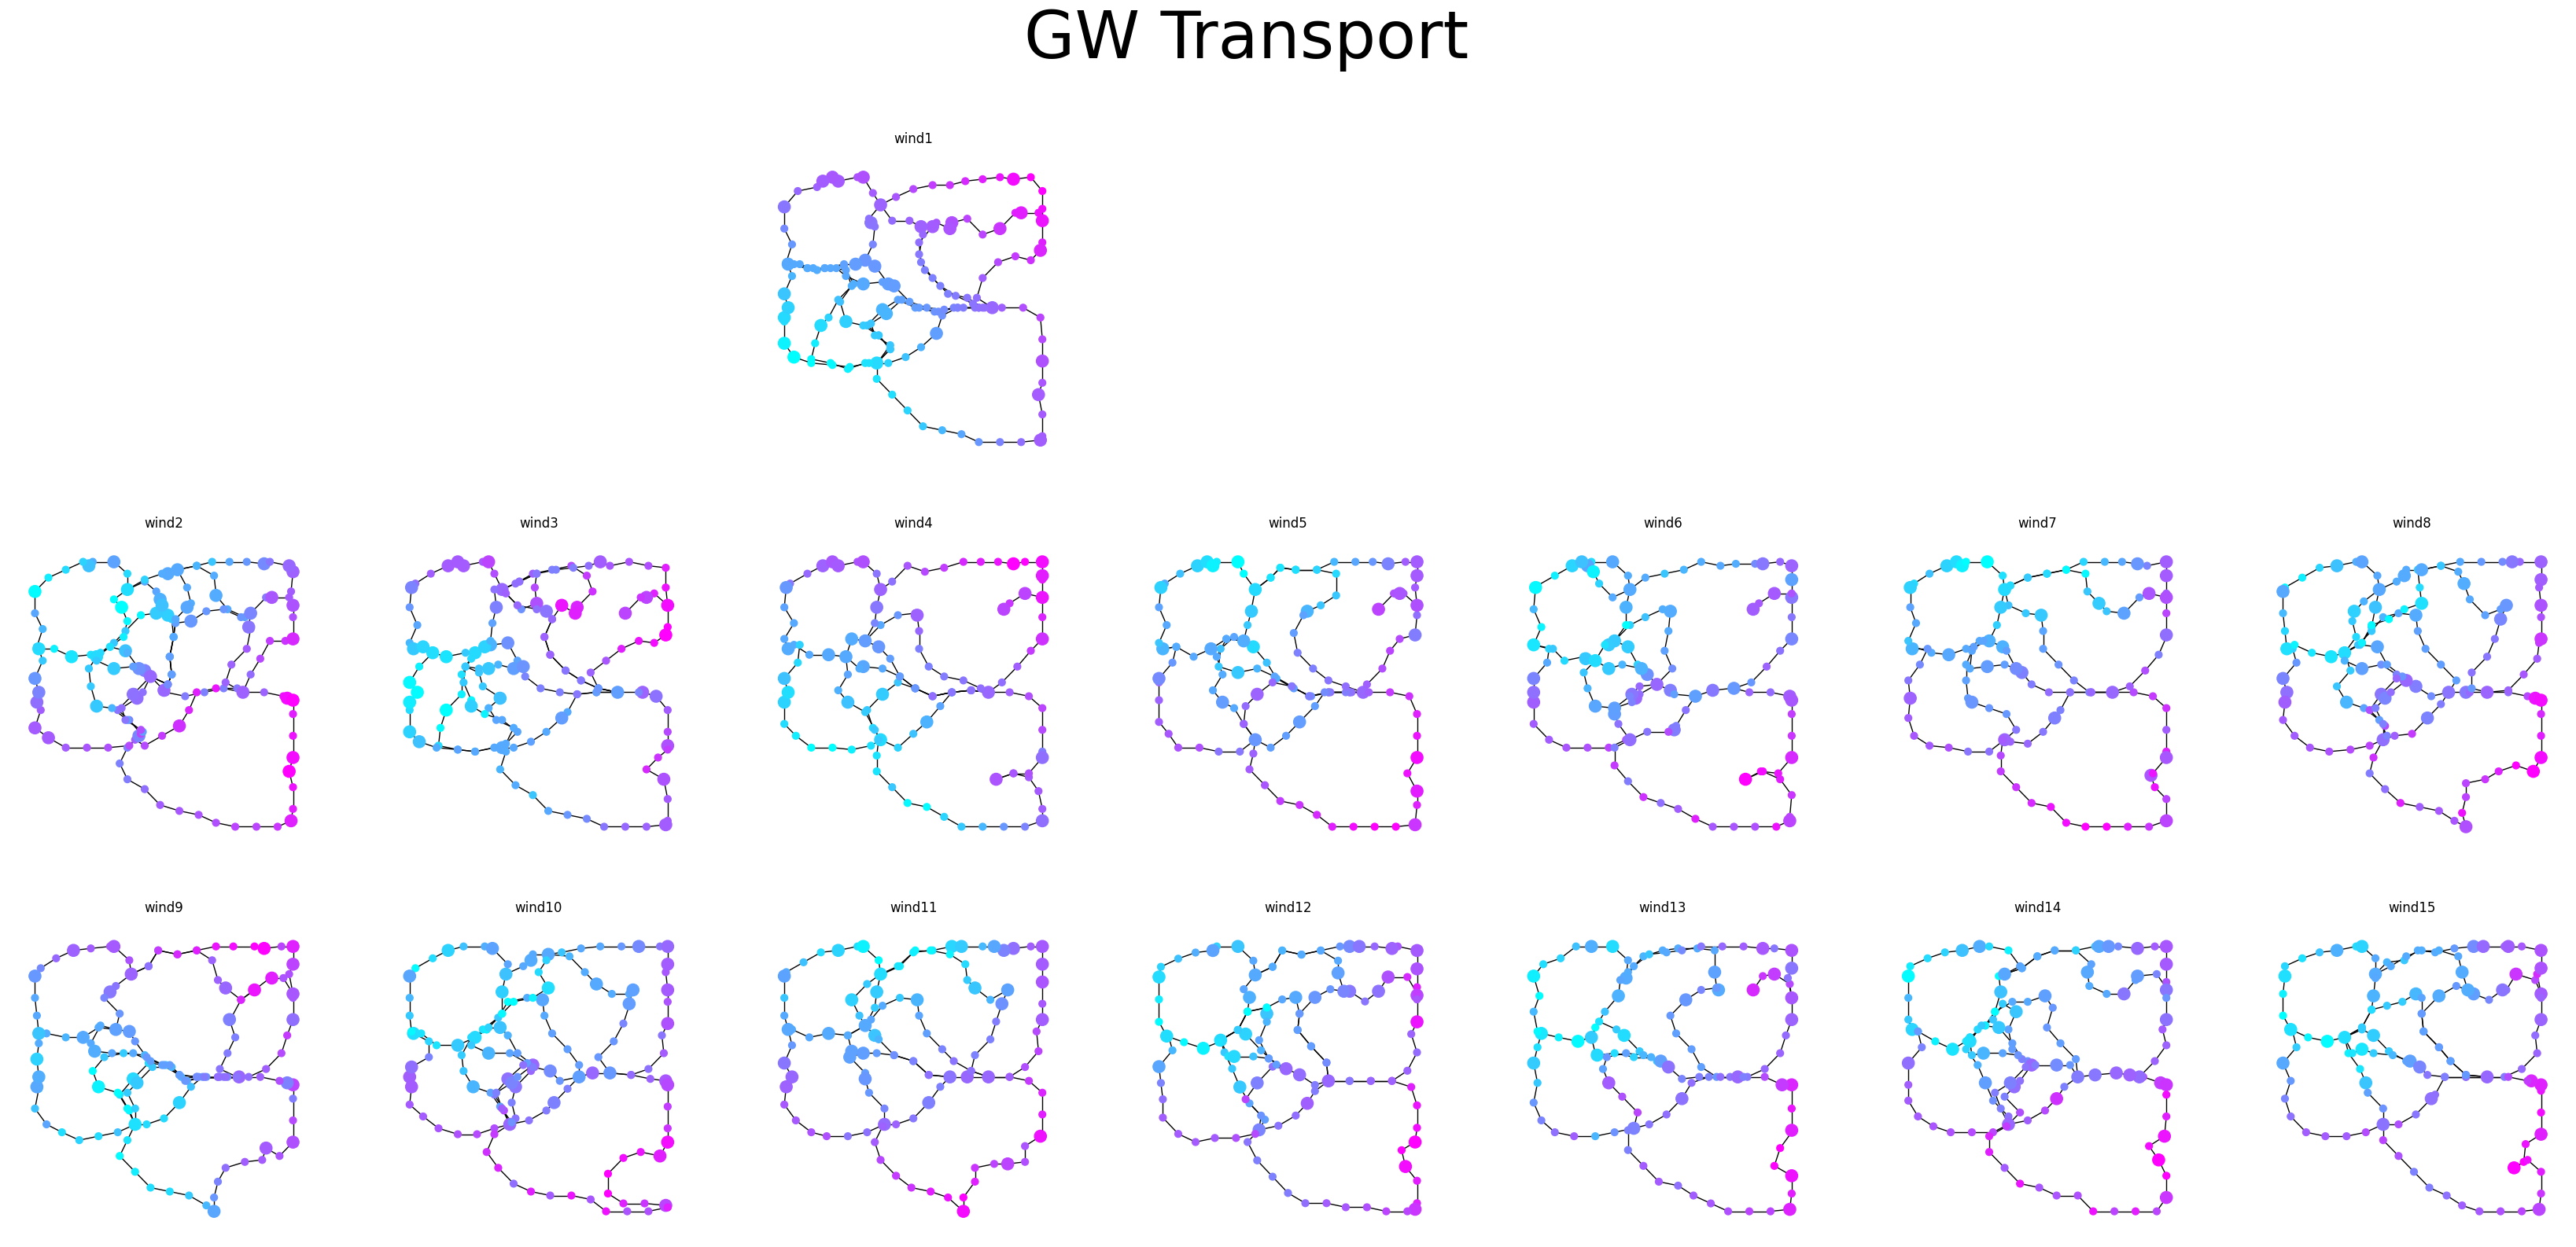

In [8]:
fig = show_transfer('GW')
fig.suptitle('GW Transport', fontsize=60)

Text(0.5, 0.98, 'Fused GW Transport')

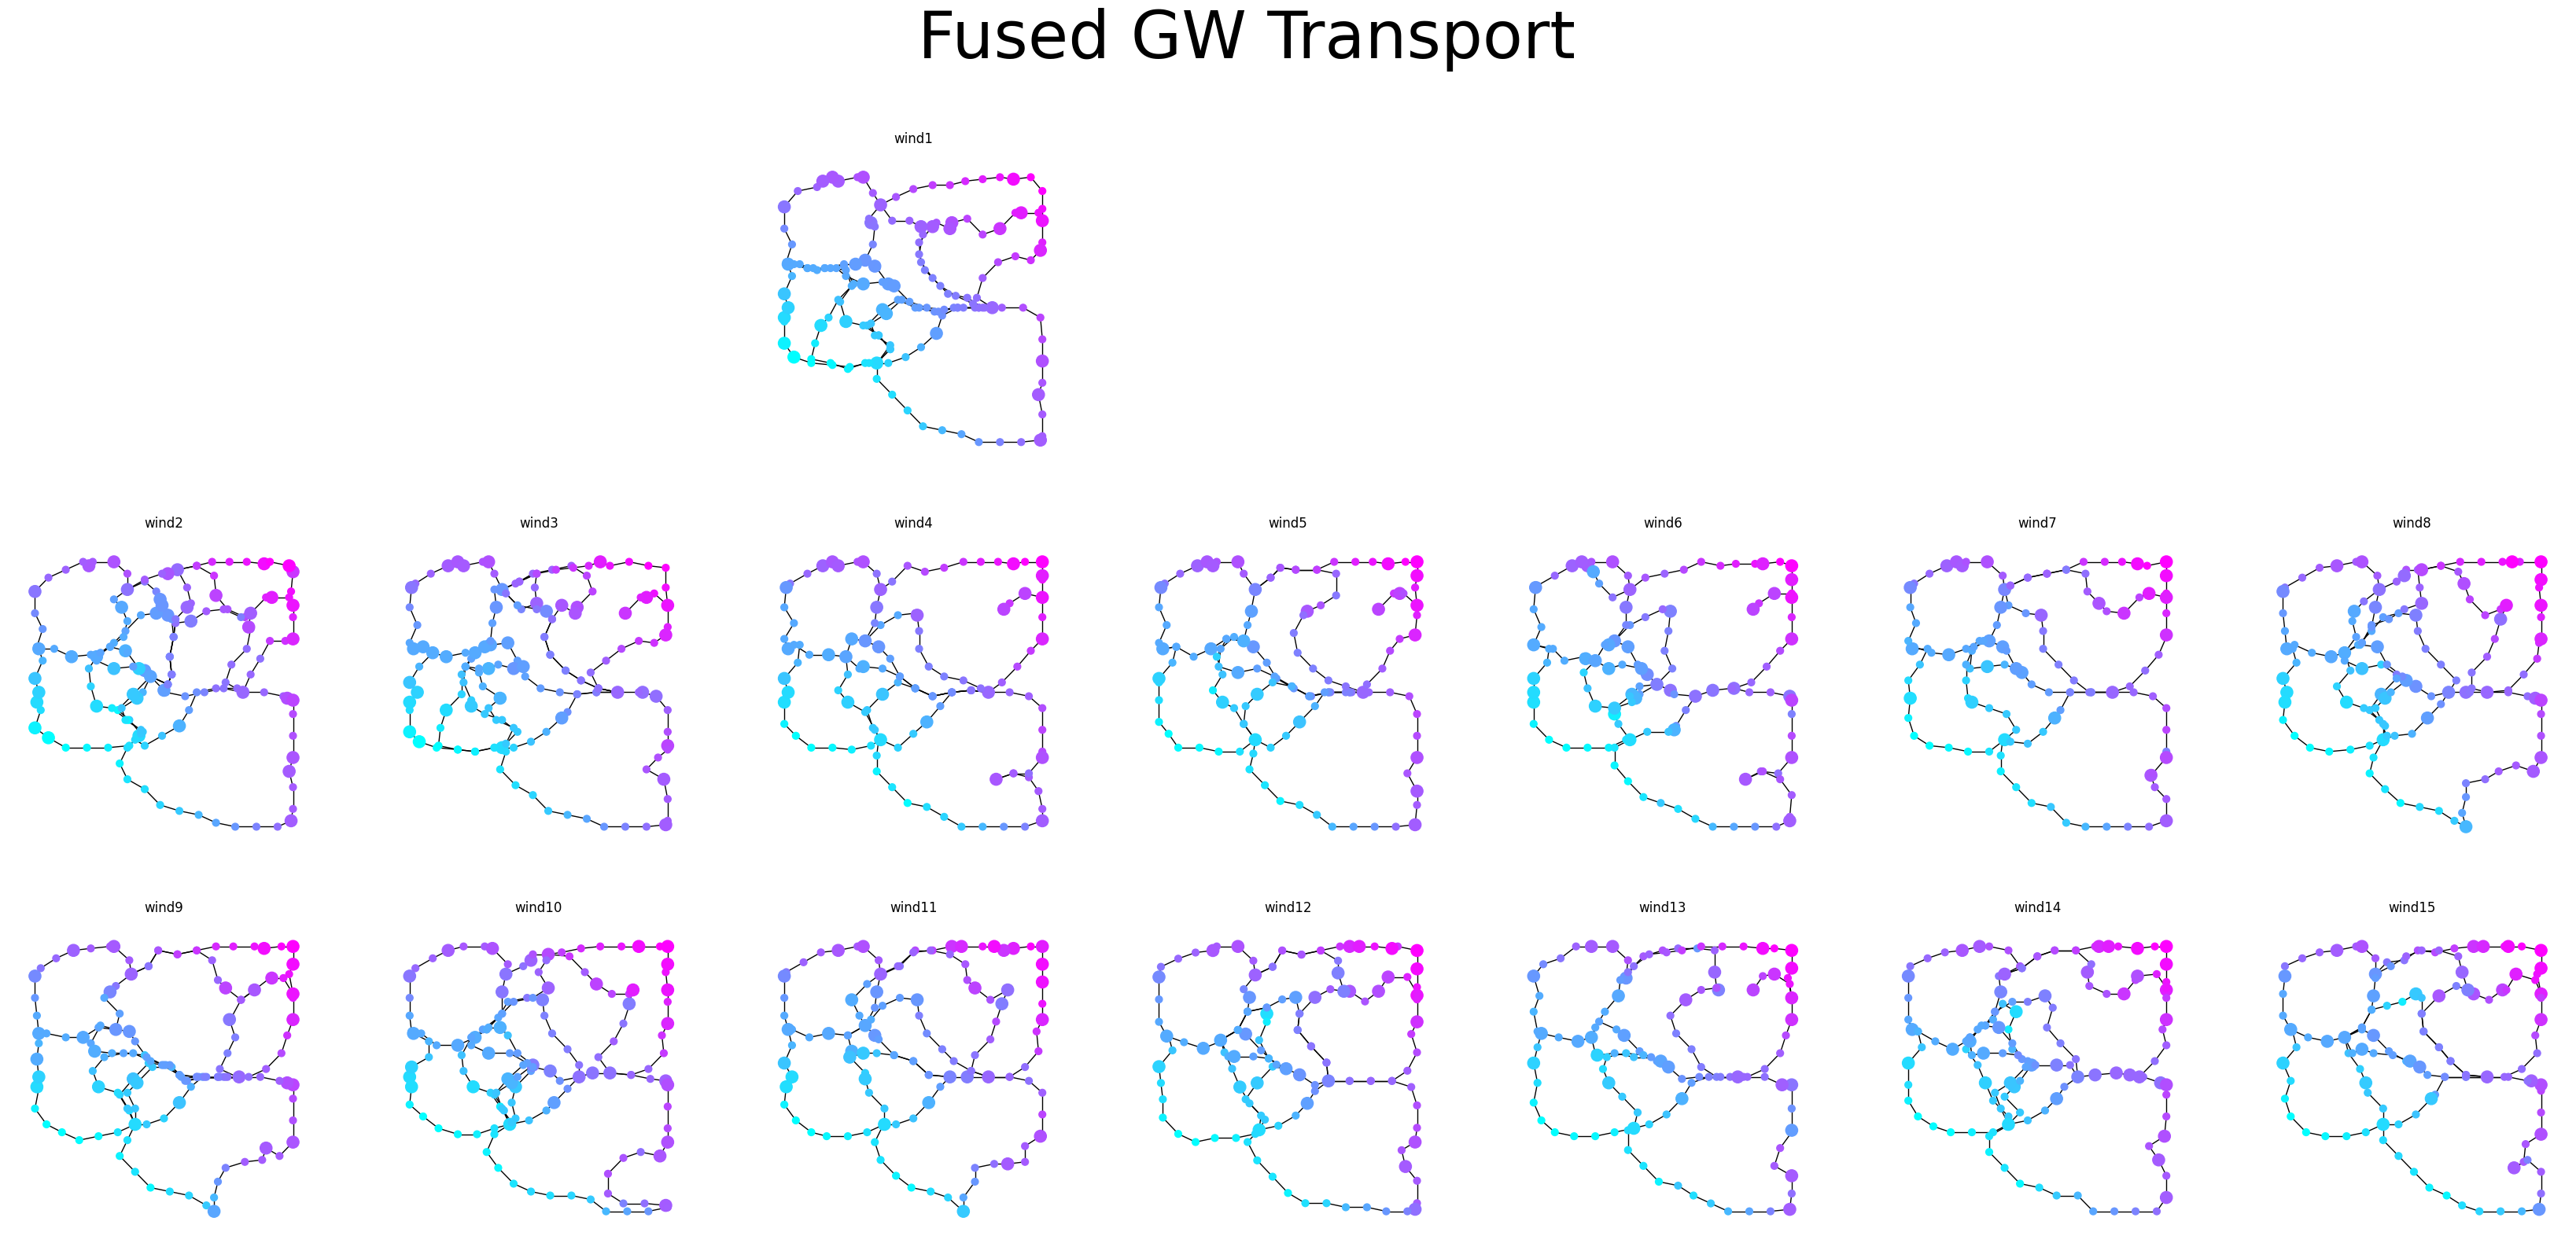

In [9]:
fig = show_transfer('fGW')
fig.suptitle('Fused GW Transport', fontsize=60)

Text(0.5, 0.98, 'Partial Fused GW Transport')

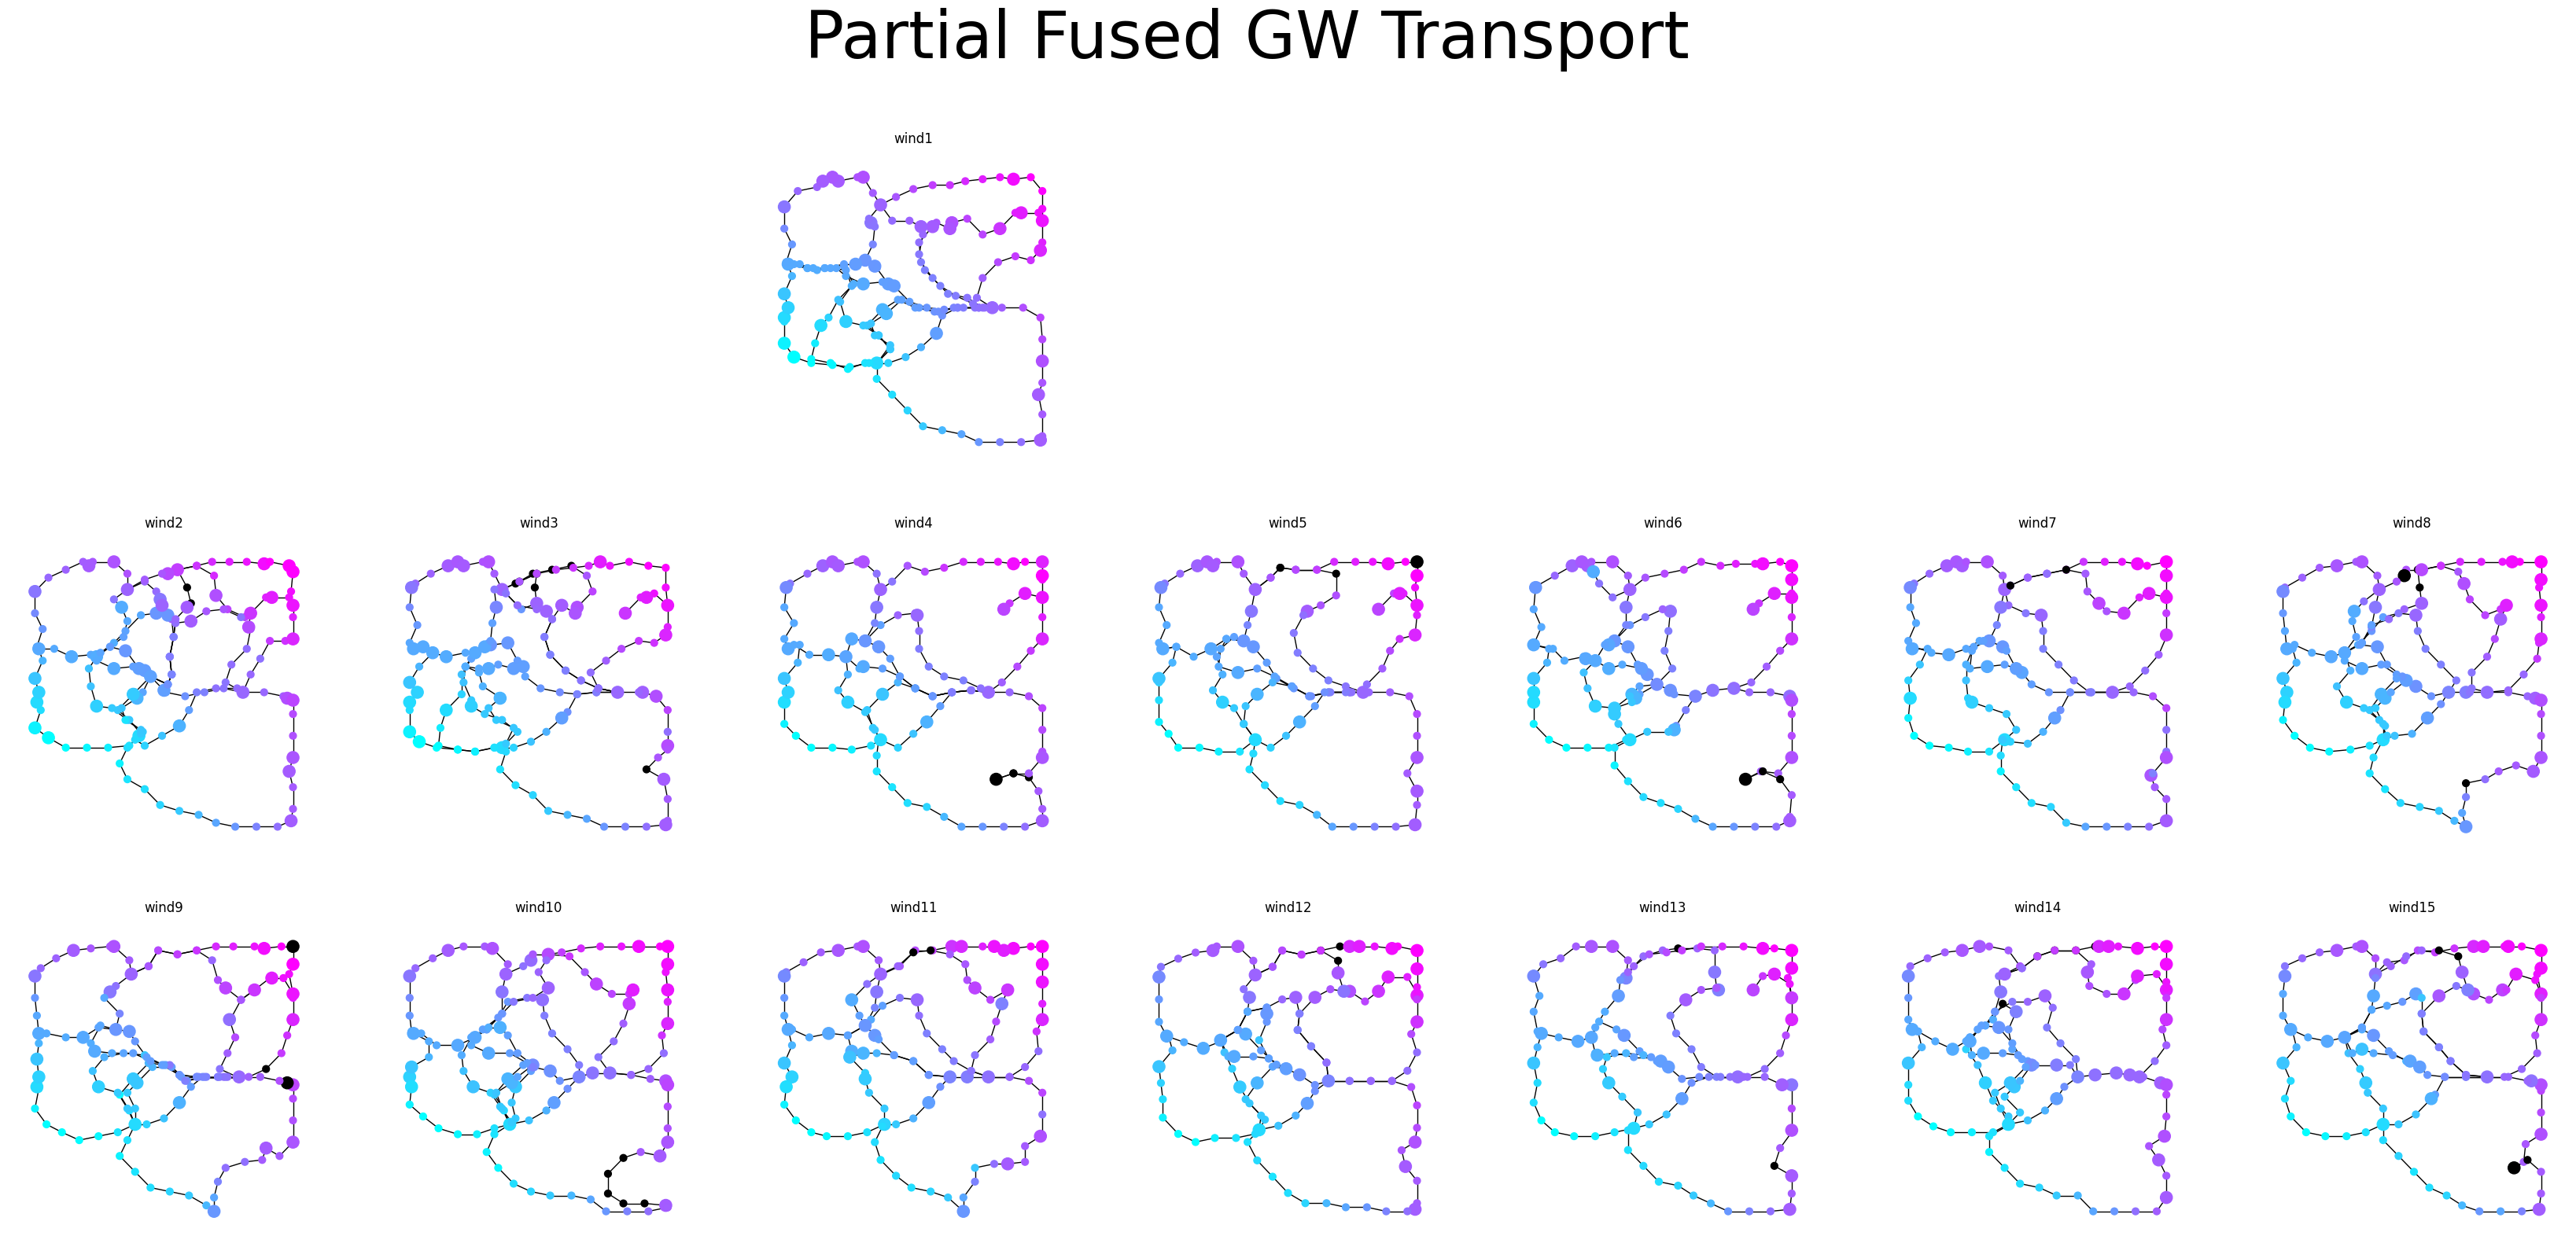

In [10]:
fig = show_transfer('fpGW')
fig.suptitle('Partial Fused GW Transport', fontsize=60)
